# DEMO++ Th analysis

In [1]:
%matplotlib inline

import os
import textwrap
import math

import datetime as dt
import pandas as pd

import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

import numpy             as np
import tables            as tb

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.reco.tbl_functions  as tbl
import invisible_cities.sierpe.blr          as blr

import seaborn as sns

from   invisible_cities.icaro. hst_functions   import display_matrix
from   invisible_cities.database               import load_db

from   matplotlib                              import gridspec
from   matplotlib.patches                      import Ellipse
from   scipy.optimize                          import curve_fit
from   scipy.interpolate                       import interp1d
from   scipy                                   import stats

from   matplotlib.colors                       import SymLogNorm

# Formatting options
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['patch.force_edgecolor'] = False
mpl.rcParams['patch.facecolor'] = 'gray'
hargs = {'histtype': 'stepfilled', 'edgecolor': 'black', 'facecolor': 'gray'}

# Directory to which figures will be stored
save_dir = "fig_DEMO_7902"
ftype = "pdf"

E_0vbb = 2458 # keV

## Function definitions

In [2]:
# Fit to 2 Gaussians
def gauss2(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    if sigma1 <= 0. or sigma2 <= 0:
        return np.inf
    return amp1/(2*np.pi)**.5/sigma1 * np.exp(-0.5*(x-mu1)**2./sigma1**2.) + amp2/(2*np.pi)**.5/sigma2 * np.exp(-0.5*(x-mu2)**2./sigma2**2.)

# Fit to Gaussian + exponential
def gaussexpo(x, amp, mu, sigma, const, mean, x0):

    if sigma <= 0.:
        return np.inf
    
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2) + const * np.exp(-(x-x0)/mean)

# (code from Gonzalo)
# Return resolution extrapolated to Qbb
def reso(values,epeak):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (epeak/2458)**0.5

# Return errors on resolution extrapolated to Qbb
def reso_errors(values,errors,epeak):
    _, mu, sigma = values
    _, err_mu, err_sigma = errors
    r = 235. * sigma/mu
    err_r = r*np.sqrt((err_sigma/sigma)**2 + (err_mu/mu)**2)
    return r, err_r, r * (epeak/2458)**0.5, err_r * (epeak/2458)**0.5

# Returns text output for Gaussian fit function
def gausstext(values,epeak):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3f}%
        R$_\\beta$$_\\beta$ = {:.3f}%""".format(*values[1:], *reso(values,epeak)))
        #$\chi^2$ = {:.2f}""".format(*values[1:], *reso(values,epeak),chi2))

# Returns text output for Gaussian fit function
def gausstext_err(values,errors,chisq,epeak):
    r,err_r,rbb,err_rbb = reso_errors(values,errors,epeak)
    return textwrap.dedent("""
        $\mu$ = {:.4f} $\pm$ {:.4f}
        $\sigma$ = {:.4f} $\pm$ {:.4f}
        R (%) = {:.2f} $\pm$ {:.2f}
        $\chi^2$/N$_\mathrm{{dof}}$ = {:.2f}""".format(values[1],errors[1],values[2],errors[2],r,err_r,chisq))
#        R$_\\beta$$_\\beta$ = {:.3f} $\pm$ {:.3f}%
    
# Returns text output for Gaussian + exponential fit function
def gaussexpotext(values,epeak):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3f}%
        R$_\\beta$$_\\beta$ = {:.3f}%""".format(*values[1:3], *reso(values[0:3],epeak)))

# Returns text output for two-Gaussian fit function
def gauss2text(values,epeak1,epeak2):
    return textwrap.dedent("""
        $\mu_1$ = {:.1f}
        $\sigma_1$ = {:.2f}
        R$_1$ = {:.3f}%
        R$_1$$_\\beta$$_\\beta$ = {:.3f}%
        $\mu_2$ = {:.1f}
        $\sigma_2$ = {:.2f}
        R$_2$ = {:.3f}%
        R$_2$$_\\beta$$_\\beta$ = {:.3f}%""".format(*values[1:3], *reso(values[0:3],epeak1), *values[4:], *reso(values[3:],epeak2)))

# Modified hst_functions.display_matrix
def display_matrix_mod(x, y, z, mask=None, **kwargs):
    """
    Display the matrix z using the coordinates x and y as the bin centers.
    """
    nx = np.size(x)
    ny = np.size(y)

    dx = (np.max(x) - np.min(x)) / nx
    dy = (np.max(y) - np.min(y)) / ny

    x_binning = np.linspace(np.min(x) - dx, np.max(x) + dx, nx + 1)
    y_binning = np.linspace(np.min(y) - dy, np.max(y) + dy, ny + 1)

    x_ = np.repeat(x, ny)
    y_ = np.tile  (y, nx)
    z_ = z.flatten()

    if mask is None:
        mask = np.ones_like(z_, dtype=bool)
        
    h, x, y = np.histogram2d(-y_[mask], x_[mask], bins=[x_binning, y_binning], weights=z_[mask], **kwargs)
    return h, x, y

# A linear function mx + b
def flinear(x, m, b):
    return m*x + b

# A quadratic function mx**2 + b
def fquadratic(x, m, b):
    return m*x**2 + b

# A sqrt function a*sqrt(x)
def fsqrt(x, a, b):
    return a*x**0.5 + b

# A 2nd order polynomial
def poly2(x, a, b, c):
    return a*x**2 + b*x + c

# A 4th-order polynomial
def poly4(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

# A 2D Gaussian
def mult_gaussFun_Fit(x_y,*m):
    (x,y) = x_y
    A,x0,y0,varx,vary,rho = m
    #print("x0 is {}".format(x0))
    X,Y = np.meshgrid(x,y)
    assert rho != 1
    a = 1/(2*(1-rho**2))
    Z = A*np.exp(-a*((X-x0)**2/(varx)+(Y-y0)**2/(vary)-(2*rho/(np.sqrt(varx*vary)))*(X-x0)*(Y-y0)))
    return Z.ravel()

# Fit function for energy resolution.
def fres(x, a, b):
    return a + b/x**0.5

-------------------------

# Save/load main event quantities

In [3]:
CAL_a = 0.0
CAL_b = 1.0 
CAL_c = 0.0

mode_correct = False

def StoE(spes, fscale=1):
    if(fscale >= 1):
        return CAL_a*spes**2 + CAL_b*spes + CAL_c
    elif(fscale < 0): # set fscale to -1 to do nothing
        return -fscale*spes
    else:
        return fscale*spes

evtfnames   = ["/Users/jrenner/local/data/DEMO/7949/cdst_combined_7949.h5"]
#                "/Users/jrenner/local/data/DEMO/7950/cdst_combined_7950.h5",
#                "/Users/jrenner/local/data/DEMO/7951/cdst_combined_7951.h5",
#                "/Users/jrenner/local/data/DEMO/7952/cdst_combined_7952.h5"]

# kalpha_mu = [0.6795, 0.6796, 0.6796, 0.6797, 0.6795]

## Load the information directly from files

`A_evtnum`      -- event number<br>
`A_time`        -- timestamp<br>
`A_eblob1`      -- energy of blob1 (most energetic) as obtained from Paolina analysis<br>
`A_eblob2`      -- energy of blob2 (least energetic) as obtained from Paolina analysis<br>
`A_emtrk`       -- energy of 10 most energetic Paolina tracks in the event<br>
`A_xmtrk`       -- average reconstructed $x$-coordinate of 10 most energetic Paolina tracks in the event<br>
`A_ymtrk`       -- average reconstructed $y$-coordinate of 10 most energetic Paolina tracks in the event<br>
`A_zmtrk`       -- average reconstructed $z$-coordinate of 10 most energetic Paolina tracks in the event<br>
`A_ntrks`       -- number of tracks in the event<br>
`A_lmtrk`       -- length of most energetic Paolina track in event<br>
`A_nvox`        -- number of voxels in the event<br>
`A_nhits`       -- number of hits in the event<br>
`A_Ec`          -- fully corrected energy (lifetime by hit + $(x,y)$ by hit)<br>
`A_Eczlen`      -- fully corrected energy + z-length correction<br>
`A_E0`          -- uncorrected energy<br>
`A_xavg`        -- average reconstructed $x$-coordinate of event<br>
`A_yavg`        -- average reconstructed $y$-coordinate of event<br>
`A_zavg`        -- average reconstructed $z$-coordinate of event<br>
`A_ravg`        -- average $r = \sqrt{x^2 + y^2}$ of event<br>
`A_xmin`        -- minimum reconstructed $x$-coordinate of event<br>
`A_ymin`        -- minimum reconstructed $y$-coordinate of event<br>
`A_zmin`        -- minimum reconstructed $z$-coordinate of event<br>
`A_xmax`        -- maximum reconstructed $x$-coordinate of event<br>
`A_ymax`        -- maximum reconstructed $y$-coordinate of event<br>
`A_zmax`        -- maximum reconstructed $z$-coordinate of event<br>
`A_rmin`        -- minimum value of $r = \sqrt{x^2 + y^2}$ over all hits in event<br>
`A_rmax`        -- maximum value of $r = \sqrt{x^2 + y^2}$ over all hits in event<br>

In [4]:
A_evtnum = []; A_time = []; A_ES1 = []
A_eblob1 = []; A_eblob2 = []; A_emtrk = []; A_etrks = []; A_xtrks = []; A_ytrks = []; A_ztrks = []
A_ntrks = []; A_lmtrk = []; A_nvox = []; A_nhits = []
A_Q0 = []; A_Qc = []
A_Ec = []; A_Eczlen = []; A_E0 = []; A_Echead = []; A_Ectail = []
A_xavg = []; A_yavg = []; A_zavg = []; A_ravg = []
A_xmin = []; A_ymin = []; A_zmin = []
A_xmax = []; A_ymax = []; A_zmax = []
A_rmin = []; A_rmax = []
A_maxtrklen = []

cdf = None
for ii,fname in enumerate(evtfnames):
 
    #fscale = kalpha_mu[0]/kalpha_mu[ii]
    #print("Adding file {} with fscale {} ...".format(fname,fscale))
    print("Adding file {} ...".format(fname))

    #fn = np.load(fname)
    ftbl = tb.open_file(fname, 'r')
    
    fsummary = ftbl.root.Summary.Events
    fdst = ftbl.root.DST.Events
    ftracks = ftbl.root.Tracking.Tracks

    # Read the tables into DataFrames.
    to_df = pd.DataFrame.from_records
    df_summary = to_df(fsummary.read())
    df_tracks = to_df(ftracks.read())
    df_dst = to_df(fdst.read())
    
    # Drop duplicates in the KDST, selecting the S1 and S2 with highest energy.
    df_dst = df_dst.sort_values(['event','S1e','S2e'])[['event','S2e','S1e']].drop_duplicates('event',keep='last')
    
    # Drop duplicates in the TDST, selecting the tracks with longest energy.
    df_tracks = df_tracks.sort_values(['event','length']).drop_duplicates('event',keep='last')
    
    # Merge into a single dataframe.
    df_merge = pd.merge(df_summary, df_dst, on = 'event', how='left')
    df_merge = pd.merge(df_merge, df_tracks, on = 'event', how='left')
    
    # Concatenate with previous runs.
    if(cdf is None):
        cdf = df_merge
    else:
        cdf = cdf.append(df_merge)

A_evtnum    = cdf['event'].values
A_maxtrklen = cdf['length'].values
A_ntrks     = cdf['evt_ntrks']
A_nhits     = cdf['evt_nhits'].values
A_Ec        = cdf['evt_energy'].values
A_xavg      = cdf['evt_x_avg'] 
A_yavg      = cdf['evt_y_avg']
A_zavg      = cdf['evt_z_avg']
A_ravg      = cdf['evt_r_avg']
A_xmin      = cdf['evt_x_min']
A_ymin      = cdf['evt_y_min']
A_zmin      = cdf['evt_z_min']
A_xmax      = cdf['evt_x_max']
A_ymax      = cdf['evt_y_max']
A_zmax      = cdf['evt_z_max']
A_rmin      = cdf['evt_r_min']
A_rmax      = cdf['evt_r_max']
# #A_time   = np.concatenate((A_time,fn['time']))
# #A_ES1    = np.concatenate((A_ES1,fn['S1e']))
# #A_eblob1 = np.concatenate((A_eblob1,fn['A_eblob1']))
# #A_eblob2 = np.concatenate((A_eblob2,fn['A_eblob2']))
# A_ntrks  = np.concatenate((A_ntrks,fn['evt_ntrks']))
# #A_lmtrk  = np.concatenate((A_lmtrk,fn['A_lmtrk']))
# #A_nvox   = np.concatenate((A_nvox,fn['A_nvox']))
# A_nhits  = np.concatenate((A_nhits,fn['evt_nhits']))
# A_Ec     = np.concatenate((A_Ec,fn['evt_energy']))
# #A_E0     = np.concatenate((A_E0,fn['S2e0']))
# A_xavg   = np.concatenate((A_xavg,fn['evt_x_avg']))
# A_yavg   = np.concatenate((A_yavg,fn['evt_y_avg']))
# A_zavg   = np.concatenate((A_zavg,fn['evt_z_avg']))
# A_ravg   = np.concatenate((A_ravg,fn['evt_r_avg']))
# A_xmin   = np.concatenate((A_xmin,fn['evt_x_min']))
# A_ymin   = np.concatenate((A_ymin,fn['evt_y_min']))
# A_zmin   = np.concatenate((A_zmin,fn['evt_z_min']))
# A_xmax   = np.concatenate((A_xmax,fn['evt_x_max']))
# A_ymax   = np.concatenate((A_ymax,fn['evt_y_max']))
# A_zmax   = np.concatenate((A_zmax,fn['evt_z_max']))
# A_rmin   = np.concatenate((A_rmin,fn['evt_r_min']))
# A_rmax   = np.concatenate((A_rmax,fn['evt_r_max']))

# # Get DST variables to merge.
# A_evtDST   = np.concatenate((A_evtDST,fdst['event']))
# A_qDST     = np.concatenate((A_qDST,fdst['S2q']))
# A_eDST     = np.concatenate((A_eDST,fdst['S2e']))

# A_Q0 = np.array(A_Q0)
# A_E0 = np.array(A_E0)  
    
# Calibrate the energy.
A_Ecal = CAL_a*A_Ec**2 + CAL_b*A_Ec + CAL_c
#A_etrks = CAL_a*A_etrks**2 + CAL_b*A_etrks + CAL_c

# Produce an array with only the energy of the maximum track for each event.
#A_emtrk = np.max(A_etrks,axis=1)
#A_emtrk = CAL_a*A_emtrk**2 + CAL_b*A_emtrk + CAL_c

# Correct for z-length effect.
A_zlen = A_zmax - A_zmin
#A_Eczlcorr = A_Ecal/(1 - 2.76e-4*A_zlen)
A_Eczlcorr = A_Ecal/(1 - 10.0e-4*A_zlen)
#A_Eczlcorr = A_Ecal/(1 + 2.0e-4*A_zlen)

beta = 1.603e-6
A_zlen_cut = np.maximum(A_zlen,2)
A_Eczlcorrb = (A_zlen_cut/(2*beta))*((1+4*A_Ecal*beta/A_zlen_cut)**0.5-1)

z_corrected = False
if(z_corrected):
    A_Ecplot = A_Eczlcorr
else:
    A_Ecplot = A_Ecal

print("{} total events".format(len(A_evtnum)))

Adding file /Users/jrenner/local/data/DEMO/7949/cdst_combined_7949.h5 ...
1332847 total events


In [5]:
rmax = cs_rmax
zmin = cs_zmin; zmax = cs_zmax
allcuts = C_basic & (A_rmax < rmax) & (A_zmin > zmin) & (A_zmax < zmax) & (A_zlen > 5) & (A_zlen < 32) & (A_Ecplot > 0.75) & (A_Ecplot < 0.79)
plt.hist(A_nhits[allcuts],bins=50,range=(25,150))
plt.xlabel("# of hits")
#plt.yscale('log')

NameError: name 'cs_rmax' is not defined

## Definition of key quantities

In [6]:
# Key variables in constructing cuts.
Emin = StoE(0); Emax = StoE(800000)                  # basic cut energy range
eb1_low = 1260; eb1_high = 1320          # blob plot intervals
eb2_low = 1596; eb2_high = 1645
eb3_low = 1690; eb3_high = 2500
Emin_emtrk = StoE(1000); Emax_emtrk = StoE(2500)     # emtrk basic energy cut range

cwide_zmin = 50; cwide_zmax = 300
cwide_rmax = 60
ctight_zmin = 150; ctight_zmax = 300
ctight_rmax = 150

xr_zmin = cwide_zmin; xr_zmax = cwide_zmax
xr_rmax = cwide_rmax

#xr_zmin = 100;   xr_zmax = 300
#xr_rmax = 150

cs_zmin = cwide_zmin; cs_zmax = cwide_zmax
cs_rmax = cwide_rmax

# cs_zmin = 160; cs_zmax = 300
# cs_rmax = 150

th_zmin = cwide_zmin; th_zmax = cwide_zmax
th_rmax = cwide_rmax

# th_zmin = 160; th_zmax = 300
# th_rmax = 150

tl_zmin = cwide_zmin; tl_zmax = cwide_zmax
tl_rmax = cwide_rmax

#tl_zmin = 160; tl_zmax = 300
#tl_rmax = 150

# ------------------------------------------------------------------------------------------
# Pre-defined cuts
C_basic       = (A_Ec > 0) & (A_Ecplot > 0) & (A_zavg < 580)
C_wide        = C_basic & (A_zmin > cwide_zmin) & (A_zmax < cwide_zmax) & (A_rmax < cwide_rmax)
C_tight       = C_basic & (A_zmin > ctight_zmin) & (A_zmax < ctight_zmax) & (A_rmax < ctight_rmax)
C_tfiducial   = (abs(A_xmax) < 100) & (abs(A_ymax) < 100) & (abs(A_xmin) < 100) & (abs(A_ymin) < 100) & (A_zavg > 50) & (A_zavg < 150)

# Peak energies
E_xKalpha = (29.112*0.00261 + 29.461*25.6 + 29.782*47.4)/(0.00261 + 25.6 + 47.4)
E_xKbeta  = (33.562*4.35 + 33.624*8.40 + 33.881*0.085 + 34.419*2.54 + 34.496*0.492)/(4.35 + 8.40 + 0.085 + 2.54 + 0.492)
E_Kr      = 41.543
E_238     = 238.632
E_511     = 511
E_583     = 583.191
E_Cs      = 661.657
E_descape = 1592.535
E_Tl      = 2614.533
print("""
E_xKalpha = {}
E_xKbeta = {}
E_Kr = {}
E_238 = {}
E_511 = {}
E_583 = {}
E_Cs = {}
E_descape = {}
E_Tl = {}
""".format(E_xKalpha,E_xKbeta,E_Kr,E_238,E_511,E_583,E_Cs,E_descape,E_Tl))

# S1-S2 cuts
mS1 = 3.6
bS1 = 50
bminusS1 = -50
bplusS1 = 150
#C_S1S2 = ((A_Ec*CAL_m + CAL_b) < (mS1*A_ES1 + bplusS1)) & ((A_Ec*CAL_m + CAL_b) > (mS1*A_ES1 + bminusS1))

print("Events in key quantities: {0}".format(len(A_evtnum)))
# print(np.sum(np.isnan(A_zmax)))
# print(A_rmax[0:100])
# print(A_E0[0:100])


E_xKalpha = 29.669410207662434
E_xKbeta = 33.76268210751875
E_Kr = 41.543
E_238 = 238.632
E_511 = 511
E_583 = 583.191
E_Cs = 661.657
E_descape = 1592.535
E_Tl = 2614.533

Events in key quantities: 1332847


/Users/jrenner/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


--------------------------

# Energy resolution analysis

## Energy spectrum (full)

655516


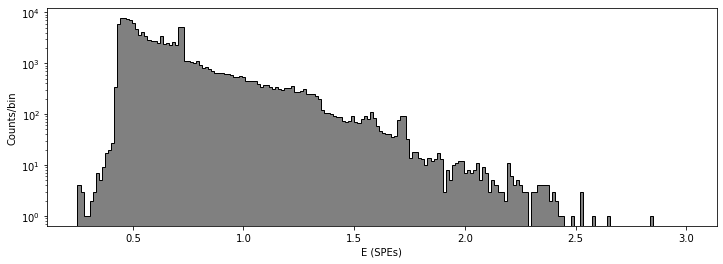

In [7]:
cuts_fullspectrum = C_wide #& (A_ntrks == 1)

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

y, x, _ = plt.hist(A_Ecplot[cuts_fullspectrum], 200, range=[StoE(0.25),StoE(3.0)], **hargs)
#y, x, _ = plt.hist(A_E0[cuts_fullspectrum], 200, range=[StoE(0.6e4),StoE(6.0e5)], **hargs)
print(np.sum(np.isnan(A_Ecplot[(A_zmin > cwide_zmin) & (A_zmax < cwide_zmax)])))
plt.xlabel('E (SPEs)')
plt.ylabel('Counts/bin')
plt.yscale('log')
# plt.annotate('$^{137}$Cs photopeak', xy=(StoE(215000), 10000),  xycoords='data',
#                  xytext=(StoE(290000), 12000), textcoords='data', fontsize=16,
#                  arrowprops=dict(arrowstyle="-"))
# plt.annotate('$^{208}$Tl e$^{+}$e$^{-}$ double-escape', xy=(StoE(520000), 2000),  xycoords='data',
#                  xytext=(StoE(580000), 10000), textcoords='data', fontsize=16,
#                  arrowprops=dict(arrowstyle="-"))
# plt.annotate('$^{208}$Tl photopeak', xy=(StoE(840000), 100),  xycoords='data',
#                 xytext=(StoE(700000), 1000), textcoords='data', fontsize=16,
#                 arrowprops=dict(arrowstyle="-"))

plt.savefig("{}/CSTH_espectrum_full.{}".format(save_dir,ftype), bbox_inches='tight')


## Energy vs. track length

/Users/jrenner/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jrenner/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Track length (mm)')

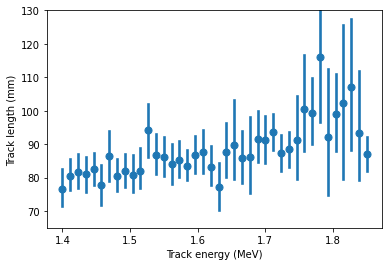

In [8]:
emin = 1.4
emax = 1.85
cuts_Evstrklen = C_wide & (A_ntrks == 1) & (A_Ecplot > emin) & (A_Ecplot < emax)

sns.regplot(x=A_Ecplot[cuts_Evstrklen], y=A_maxtrklen[cuts_Evstrklen], x_bins=np.linspace(emin,emax,40), fit_reg=None)
plt.ylim([65,130])
plt.xlabel("Track energy (MeV)")
plt.ylabel("Track length (mm)")

In [9]:
np.linspace(0,1,10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

## Energy vs. z-length

In [10]:
# Plot the energy vs. z-length.
def plot_E_vs_zlength(L_zlen, L_Ecplot, cuts_base, plt_rng_zlow, plt_rng_zhigh, plt_rng_Elow, plt_rng_Ehigh, nbins_E, nbins_z, mbound, b0, b1, plt_corrected = False, sipms = False):
    
    # Construct the cuts including the range in (z,E) space to be examined.
    cuts_bounds = (L_Ecplot > L_zlen*mbound + b0) & (L_Ecplot < L_zlen*mbound + b1)
    cuts_range = cuts_base & (L_zlen > plt_rng_zlow) & (L_zlen < plt_rng_zhigh) & (L_Ecplot > plt_rng_Elow) & (L_Ecplot < plt_rng_Ehigh)
    cuts_all = cuts_range & cuts_bounds
    
    # Assume an approximate 1% FWHM sigma on the energy measurements.
    esigma = 1.0*np.mean(L_Ecplot[cuts_all])/235
    
    # Perform the linear fit and extract the parameters.
    p_fit, V_fit = curve_fit(flinear, L_zlen[cuts_all], L_Ecplot[cuts_all], sigma=np.ones(len(L_zlen[cuts_all]))*esigma)
    m = p_fit[0]
    b = p_fit[1]
    var_m = V_fit[0][0]
    var_b = V_fit[1][1]
    var_mb = V_fit[0][1]
    xfit = np.arange(plt_rng_zlow, plt_rng_zhigh, (plt_rng_zhigh-plt_rng_zlow)/100)
    polyfit = np.poly1d([m, b])
    mb_err = (var_m/b**2 + m**2*var_b/b**4 - m*var_mb/b**3)**0.5
    print("Slope for correction {} +/- {}; intercept: {} +/- {}".format(m, var_m**0.5, b, var_b**0.5))
    print("Uncertainty in m/b = {}".format(mb_err))
    
    # Construct the boundary polynomials.
    polyfit_b0 = np.poly1d([mbound, b0])
    polyfit_b1 = np.poly1d([mbound, b1])
    
    # Create the plot.
    fig = plt.figure()
    fig.set_figheight(6.0)
    fig.set_figwidth(16.0)
    
    ax1 = fig.add_subplot(121)
    h, x, y = np.histogram2d(-L_Ecplot[cuts_range], L_zlen[cuts_range], bins=[nbins_E, nbins_z], range=[[-plt_rng_Ehigh,-plt_rng_Elow],[plt_rng_zlow,plt_rng_zhigh]])
    plt.imshow(h, extent=[plt_rng_zlow,plt_rng_zhigh,plt_rng_Elow,plt_rng_Ehigh], interpolation = "none", cmap='jet', aspect=(plt_rng_zhigh-plt_rng_zlow)/(plt_rng_Ehigh-plt_rng_Elow))
    plt.plot(xfit, polyfit_b0(xfit), '--', color='red')
    plt.plot(xfit, polyfit_b1(xfit), '--', color='red')
    plt.plot(xfit, polyfit(xfit), '-', color='red', linewidth=3, label="m/b = ({:.2f} $\pm$ {:.2f}) $\\times 10^{{-4}}$ mm$^{{-1}}$".format(m/b*1e4,mb_err*1e4))
    plt.locator_params(axis='y', nbins=7)
    plt.legend(loc=1, fontsize=14)
    plt.colorbar()
    #plt.title("")
    plt.ylim([plt_rng_Elow,plt_rng_Ehigh])
    plt.xlim([plt_rng_zlow,plt_rng_zhigh])
    plt.xlabel('z-length (mm)')
    if(sipms): plt.ylabel('Q (pes)')
    else:      plt.ylabel('E (MeV)')
    
    if(plt_corrected):
        E_rng = plt_rng_Ehigh - plt_rng_Elow
        ax2 = fig.add_subplot(122)
        h, x, y = np.histogram2d(-L_Ecplot[cuts_range]/(1+(m/b)*L_zlen[cuts_range]), L_zlen[cuts_range], bins=[nbins_E, nbins_z], range=[[-(b+E_rng/2),-(b-E_rng/2)],[plt_rng_zlow,plt_rng_zhigh]])
        plt.imshow(h, extent=[plt_rng_zlow,plt_rng_zhigh,b-E_rng/2,b+E_rng/2], interpolation = "none", cmap='jet', aspect=(plt_rng_zhigh-plt_rng_zlow)/E_rng)
        #plt.plot(xfit, polyfit_b0(xfit), '--', color='red')
        #plt.plot(xfit, polyfit_b1(xfit), '--', color='red')
        #plt.plot(xfit, polyfit(xfit), '-', color='red', linewidth=3, label="m/b = {:.2f} $\\times 10^{{-4}}$ mm$^{{-1}}$".format(m/b*1e4))
        #plt.legend(loc=1, fontsize=14)
        plt.colorbar()
        plt.title("Energy vs. z-length, CORRECTED")
        plt.ylim([b-E_rng/2,b+E_rng/2])
        plt.xlim([plt_rng_zlow,plt_rng_zhigh])
        plt.xlabel('z-length (mm)')
        if(sipms): plt.ylabel('Q (pes)')
        else:      plt.ylabel('E (MeV)')

/Users/jrenner/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/jrenner/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


Slope for correction -0.0008998432221449578 +/- 2.127903466861876e-05; intercept: 0.7328695105350761 +/- 0.0004256232895911663
Uncertainty in m/b = 2.8700849927755853e-05


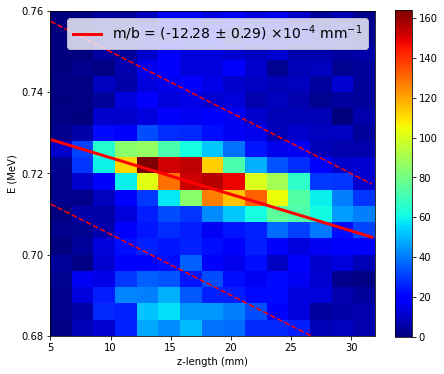

In [11]:
# for Cs peak
if(z_corrected):
    mbound = 0.0
    b0 = 0.705
    b1 = 0.749
    plt_rng_zlow = 5
    plt_rng_zhigh = 32
    plt_rng_Elow = StoE(0.68)
    plt_rng_Ehigh = StoE(0.76)
else:
    mbound = -0.0015
    b0 = 0.72
    b1 = 0.765
    plt_rng_zlow = 5
    plt_rng_zhigh = 32
    plt_rng_Elow = StoE(0.68)
    plt_rng_Ehigh = StoE(0.76)    
    
cuts_base = C_wide & (A_ntrks == 1) & (A_yavg >= A_xavg)
plot_E_vs_zlength(A_zlen, A_Ecplot, cuts_base, plt_rng_zlow, plt_rng_zhigh, plt_rng_Elow, plt_rng_Ehigh, 20, 15, mbound, b0, b1)
plt.savefig("{}/CSTH_zwidth_fit_Cs.{}".format(save_dir,'png'), bbox_inches='tight')

In [ ]:
# for double-escape peak
if(z_corrected):
    mbound = 0.0038
    b0 = 1.545
    b1 = 1.68
    plt_rng_zlow = 25
    plt_rng_zhigh = 80
    plt_rng_Elow = StoE(1.6)
    plt_rng_Ehigh = StoE(1.95)
else:
    mbound = 0.0
    b0 = 1.64
    b1 = 1.76
    plt_rng_zlow = 25
    plt_rng_zhigh = 80
    plt_rng_Elow = StoE(1.55)
    plt_rng_Ehigh = StoE(1.85)

cuts_base = C_wide & (A_ntrks == 1)
plot_E_vs_zlength(A_zlen, A_Ecplot, cuts_base, plt_rng_zlow, plt_rng_zhigh, plt_rng_Elow, plt_rng_Ehigh, 20, 20, mbound, b0, b1)
plt.savefig("{}/CSTH_zwidth_fit_DE.{}".format(save_dir,'png'), bbox_inches='tight')

In [ ]:
# for Tl peak
mbound = -0.0008
b0 = 2.72
b1 = 2.79
plt_rng_zlow = 30
plt_rng_zhigh = 140
plt_rng_Elow = StoE(2.64)
plt_rng_Ehigh = StoE(2.77)

cuts_base = C_wide & (A_ntrks == 1)
plot_E_vs_zlength(A_zlen, A_Ecplot, cuts_base, plt_rng_zlow, plt_rng_zhigh, plt_rng_Elow, plt_rng_Ehigh, 15, 15, mbound, b0, b1)
plt.savefig("{}/CSTH_zwidth_fit_Tl.{}".format(save_dir,'png'), bbox_inches='tight')

In [ ]:
plt.hist(A_Q0[(A_Ecplot > 0.65) & (A_Ecplot < 0.70)],bins=100, range=(10,18000))
#plt.hist(A_Q0[(A_Ecplot > 1.62) & (A_Ecplot < 1.70)],bins=100, range=(25000,45000))
#plt.hist(A_Q0[(A_Ecplot > 2.7) & (A_Ecplot < 2.85)],bins=100, range=(40000,70000))

In [ ]:
# for Cs peak
mbound = -50
b0 = 12000
b1 = 15500
plt_rng_zlow = 8
plt_rng_zhigh = 40
plt_rng_Elow = 9000
plt_rng_Ehigh = 16000
eng_low = 0.71
eng_high = 0.76

cuts_base = C_wide & (A_ntrks == 1) & (A_Ecplot > eng_low) & (A_Ecplot < eng_high)
plot_E_vs_zlength(A_zlen, A_Q0, cuts_base, plt_rng_zlow, plt_rng_zhigh, plt_rng_Elow, plt_rng_Ehigh, 20, 12, mbound, b0, b1, sipms=True)
plt.savefig("{}/CSTH_zwidth_sipm_Cs.{}".format(save_dir,'png'), bbox_inches='tight')

In [ ]:
# for DE peak
mbound = -80
b0 = 28000
b1 = 42500
plt_rng_zlow = 15
plt_rng_zhigh = 100
plt_rng_Elow = 20000
plt_rng_Ehigh = 45000
eng_low = 1.62
eng_high = 1.80

cuts_base = C_wide & (A_ntrks == 1) & (A_Ecplot > eng_low) & (A_Ecplot < eng_high)
plot_E_vs_zlength(A_zlen, A_Q0, cuts_base, plt_rng_zlow, plt_rng_zhigh, plt_rng_Elow, plt_rng_Ehigh, 20, 12, mbound, b0, b1, sipms=True)
plt.savefig("{}/CSTH_zwidth_sipm_DE.{}".format(save_dir,'png'), bbox_inches='tight')

In [ ]:
# for Tl photopeak
mbound = -80
b0 = 60000
b1 = 78000
plt_rng_zlow = 25
plt_rng_zhigh = 120
plt_rng_Elow = 52000
plt_rng_Ehigh = 74000
eng_low = 2.7
eng_high = 2.85

cuts_base = C_wide & (A_ntrks == 1) & (A_Ecplot > eng_low) & (A_Ecplot < eng_high)
plot_E_vs_zlength(A_zlen, A_Q0, cuts_base, plt_rng_zlow, plt_rng_zhigh, plt_rng_Elow, plt_rng_Ehigh, 20, 12, mbound, b0, b1, sipms=True)
plt.savefig("{}/CSTH_zwidth_sipm_DE.{}".format(save_dir,'png'), bbox_inches='tight')

# Energy spectrum (Cs 662 keV peak)

Fit parameters are (amp, mu, sigma, A, mean, x0)
[ 1.62079259e+01  7.18248903e-01  6.05007019e-03  6.28045274e+04
 -1.71116427e+05  1.16786640e+05]
Fit errors are (amp, mu, sigma)
[4.47745106e-01 9.81388273e-05 1.24903825e-04 1.33891504e+04
 3.72043003e+04 2.58211560e+04]
Fit p-value assuming obtained chi2 and 1 d.o.f. is 0.08709183726858583
Fit range: (0.695,0.748)
Fit range from mu in sigma: (-3.8427492926935893,4.917479648553393)
Resolution is 1.9794899643733732 +/- 0.040867506550689145
Resolution at Qbb is 1.0270198101487036 +/- 0.021203309728436148
Mean track length is 15.634324708537664 +/- 6.27670412358003


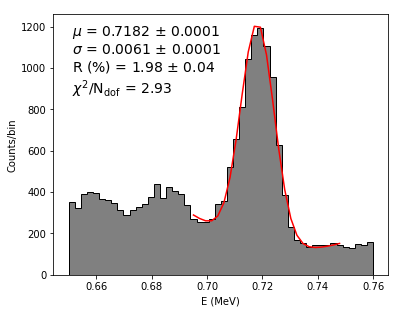

In [12]:
rmax = cs_rmax
zmin = cs_zmin; zmax = cs_zmax
rcuts = C_basic & (A_rmax < rmax) & (A_zmin > zmin) & (A_zmax < zmax) & (A_zlen > 5) & (A_zlen < 32) #& (A_ntrks == 1)
fscale = 1 # E_Cs/2.09446644e+05

if(z_corrected):
    plt_rng = [StoE(0.66,fscale),StoE(0.77,fscale)]
    text_x = 0.997*plt_rng[0]
    nbins = 40
    nxybins = 25

    fit_rng_low = StoE(0.70,fscale)
    fit_rng_high = StoE(0.75,fscale)
    fit_gauss_A = 120
    fit_gauss_mu = StoE(0.72,fscale)
    fit_gauss_sigma = StoE(0.01,fscale)
    fit_exp_A = 50
    fit_exp_mean = StoE(3.0e4,fscale)
    fit_exp_x0 = StoE(1.6e5,fscale)
    
else:
    plt_rng = [StoE(0.65,fscale),StoE(0.76,fscale)]
    text_x = 1.002*plt_rng[0]
    nbins = 50
    nxybins = 25

    fit_rng_low = StoE(0.695,fscale)
    fit_rng_high = StoE(0.748,fscale)
    fit_gauss_A = 1000
    fit_gauss_mu = StoE(0.72,fscale)
    fit_gauss_sigma = StoE(0.02,fscale)
    fit_exp_A = 50
    fit_exp_mean = StoE(3.0e4,fscale)
    fit_exp_x0 = StoE(1.6e5,fscale)

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.8)
fig.set_figwidth(6.0)

#ax1 = fig.add_subplot(121)
y0, x0, _ = plt.hist(A_Ecplot[rcuts]*fscale, nbins, range=plt_rng, **hargs)

# Gaussian fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
x, y, sig = x[sel], y0[sel], np.sqrt(y0[sel])
f    = fitf.fit(lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.polynom(x, *args[3:]), x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma, 1, -1/fit_gauss_mu, -1/fit_gauss_mu**2), sigma=sig)
#f    = fitf.fit(gaussexpo, x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma, fit_exp_A, fit_exp_mean, fit_exp_x0))
plt.plot(x, f.fn(x), "r")
plt.text(text_x, 4.4*max(y)/6, gausstext_err(f.values[0:3],f.errors[0:3],f.chi2,E_Cs),fontsize=14)
plt.xlabel('E (MeV)')
plt.ylabel('Counts/bin')
#plt.title("Rmax < {}, {} < Zmax < {}".format(rmax,zmin,zmax), fontsize=12, fontweight='bold')
print("Fit parameters are (amp, mu, sigma, A, mean, x0)")
print(f.values)
print("Fit errors are (amp, mu, sigma)")
print(f.errors)
print("Fit p-value assuming obtained chi2 and 1 d.o.f. is {}".format(1-stats.chi2.cdf(f.chi2, 1)))

# Compute the statistical error.
mu = f.values[1]
sigma = f.values[2]
s_mu = f.errors[1]
s_sigma = f.errors[2]
R = sigma/mu
s_R = (s_sigma**2 + R**2*s_mu**2)**0.5/mu
print("Fit range: ({},{})".format(fit_rng_low,fit_rng_high))
print("Fit range from mu in sigma: ({},{})".format((fit_rng_low-mu)/sigma,(fit_rng_high-mu)/sigma))
print("Resolution is {} +/- {}".format(235*R,235*s_R))
print("Resolution at Qbb is {} +/- {}".format(235*R*(E_Cs/E_0vbb)**0.5,235*s_R*(E_Cs/E_0vbb)**0.5))

xyz_rng_low_Cs = fit_rng_low
xyz_rng_high_Cs = fit_rng_high

# ax4 = fig.add_subplot(122) 
# h, x, y = np.histogram2d(-A_yavg[rcuts & (A_Ecplot > xyz_rng_low) & (A_Ecplot < xyz_rng_high)], A_xavg[rcuts & (A_Ecplot > xyz_rng_low) & (A_Ecplot < xyz_rng_high)], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
# plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
# plt.colorbar()
# plt.xlabel("average x (mm)")
# plt.ylabel("average y (mm)")
# plt.title("x,y for $E\in ({},{})$".format(xyz_rng_low,xyz_rng_high), fontsize=14)

# Save relevant fit parameters for later use
mu_cs_fid      = f.values[1] 
e_mu_cs_fid    = f.errors[1]
sigma_cs_fid   = f.values[2]
e_sigma_cs_fid = f.errors[2]

# Determine the mean and sigma of z-length.
zlen_mean  = np.mean(A_zlen[rcuts])
zlen_sigma = np.std(A_zlen[rcuts])
print("Mean track length is {} +/- {}".format(zlen_mean,zlen_sigma))
zlen_Cs_mean  = zlen_mean
zlen_Cs_sigma = zlen_sigma

plt.savefig("{}/CSTH_espectrum_Cs_fit_zcorrected_universal.{}".format(save_dir,ftype), bbox_inches='tight')

# Energy spectrum (208Tl double-escape peak)

Fit parameters (amp , mu, sigma, A, mean, x0)
[ 1.41780771e+00  1.71819415e+00  1.29785511e-02 -7.05650616e+03
  7.92705575e+03 -2.22447446e+03]
Fit errors (amp, mu, sigma, A, mean, x0)
[6.63931947e-01 2.72452525e-03 3.00662269e-03 8.42081068e+03
 9.42550930e+03 2.63728135e+03]
Fit p-value assuming obtained chi2 and 1 d.o.f. is 0.39218276356433146
Fit range: (1.705,1.82)
Fit range from mu in sigma: (-1.0166120472812972,7.844161302145214)
Resolution is 1.7750959714736139 +/- 0.411229943092297
Resolution at Qbb is 1.4288129968695211 +/- 0.21335864575388705
Mean track length is 52.61351506762444 +/- 10.231111104760004


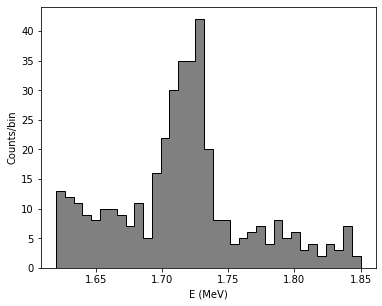

In [13]:
# fit double-escape peak with and without profile corrections
rmax = th_rmax
zmin = th_zmin; zmax = th_zmax
rcuts = C_basic & (A_rmax < rmax) & (A_zmin > zmin) & (A_zmax < zmax) & (A_zlen > 40) & (A_zlen < 80) #& (A_ntrks == 1)
fscale = 1 # E_descape/5.13611473e+05

nbins = 35
nxybins = 25

if(z_corrected):
    #plt_rng = [StoE(1.60,fscale),StoE(1.72,fscale)]
    plt_rng = [StoE(1.55,fscale),StoE(1.75,fscale)]
    text_x = 1.0*plt_rng[0]

#     fit_rng_low = StoE(1.635,fscale)
#     fit_rng_high = StoE(1.705,fscale)
    fit_rng_low = StoE(1.620,fscale)
    fit_rng_high = StoE(1.700,fscale)
    fit_gauss_A = 200
    fit_gauss_mu = StoE(1.67,fscale)
    fit_gauss_sigma = StoE(0.1,fscale)
    fit_exp_A = 80
    fit_exp_mean = StoE(1.16e5,fscale)
    fit_exp_x0 = StoE(2.1e2,fscale)
    
else:
    plt_rng = [StoE(1.62,fscale),StoE(1.85,fscale)]
    text_x = 1.015*plt_rng[-1]

    fit_rng_low = StoE(1.705,fscale)
    fit_rng_high = StoE(1.82,fscale)
    fit_gauss_A = 200
    fit_gauss_mu = StoE(1.72,fscale)
    fit_gauss_sigma = StoE(0.1,fscale)
    fit_exp_A = 60
    fit_exp_mean = StoE(1.16e5,fscale)
    fit_exp_x0 = StoE(2.1e2,fscale)

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.8)
fig.set_figwidth(6.0)

y0, x0, _ = plt.hist(A_Ecplot[rcuts]*fscale, nbins, range=plt_rng, **hargs)
#y0, x0, _ = plt.hist(1592*(A_Ec[rcuts]*CAL_m + CAL_b)/prof_D(A_zmax[rcuts] - A_zmin[rcuts]), nbins, range=plt_rng, **hargs)

# Gaussian fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
x, y, sig = x[sel], y0[sel], np.sqrt(y0[sel])
f    = fitf.fit(lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.polynom(x, *args[3:]), x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma, 1, -1/fit_gauss_mu, -1/fit_gauss_mu**2), sigma=sig)
#plt.plot(x, f.fn(x), "r")
#plt.text(text_x, 4.6*max(y)/6, gausstext_err(f.values[0:3],f.errors[0:3],f.chi2,E_descape),fontsize=14)

plt.xlabel('E (MeV)')
plt.ylabel('Counts/bin')
#plt.title("Rmax < {}, {} < Zmax < {}".format(rmax,zmin,zmax), fontsize=12, fontweight='bold')
print("Fit parameters (amp , mu, sigma, A, mean, x0)")
print(f.values)
print("Fit errors (amp, mu, sigma, A, mean, x0)")
print(f.errors)
print("Fit p-value assuming obtained chi2 and 1 d.o.f. is {}".format(1-stats.chi2.cdf(f.chi2, 1)))
#print(len(A_Ecplot[rcuts & (A_Ecplot > 1550) & (A_Ecplot < 1650)]))

# Compute the statistical error.
mu = f.values[1]
sigma = f.values[2]
s_mu = f.errors[1]
s_sigma = f.errors[2]
R = sigma/mu
s_R = (s_sigma**2 + R**2*s_mu**2)**0.5/mu
print("Fit range: ({},{})".format(fit_rng_low,fit_rng_high))
print("Fit range from mu in sigma: ({},{})".format((fit_rng_low-mu)/sigma,(fit_rng_high-mu)/sigma))
print("Resolution is {} +/- {}".format(235*R,235*s_R))
print("Resolution at Qbb is {} +/- {}".format(235*R*(E_descape/E_0vbb)**0.5,235*s_R*(E_Cs/E_0vbb)**0.5))

xyz_rng_low_DE = fit_rng_low
xyz_rng_high_DE = fit_rng_high

# ax4 = fig.add_subplot(122) 
# h, x, y = np.histogram2d(-A_yavg[rcuts & (A_Ecplot > xyz_rng_low) & (A_Ecplot < xyz_rng_high)], A_xavg[rcuts & (A_Ecplot > xyz_rng_low) & (A_Ecplot < xyz_rng_high)], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
# plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
# plt.colorbar()
# plt.xlabel("average x (mm)")
# plt.ylabel("average y (mm)")
# plt.title("x,y for $E\in ({},{})$".format(xyz_rng_low,xyz_rng_high), fontsize=14)

# Save relevant fit parameters for later use
mu_de_fid      = f.values[1] 
e_mu_de_fid    = f.errors[1]
sigma_de_fid   = f.values[2]
e_sigma_de_fid = f.errors[2]

# Determine the mean and sigma of z-length.
zlen_mean  = np.mean(A_zlen[rcuts])
zlen_sigma = np.std(A_zlen[rcuts])
print("Mean track length is {} +/- {}".format(zlen_mean,zlen_sigma))
zlen_de_mean  = zlen_mean
zlen_de_sigma = zlen_sigma

plt.savefig("{}/CSTH_espectrum_doubleescape_fit_zcorrected_universal.{}".format(save_dir,ftype), bbox_inches='tight')

In [14]:
evt_cuts = C_basic & (A_rmax < rmax) & (A_zmin > zmin) & (A_zmax < zmax) & (A_zlen > 40) & (A_zlen < 80) & (A_Ecplot > 1.68) & (A_Ecplot < 1.75)
evt_nums = A_evtnum[evt_cuts]
np.savez("evts_7949_doubleescape.npz",evt_numbers=evt_nums)

/Users/jrenner/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/Users/jrenner/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


# Energy spectrum (208Tl photopeak)

In [ ]:
# fit 208Tl photopeak for paper
rmax = tl_rmax
zmin = tl_zmin 
zmax = tl_zmax
rcuts = C_basic & (A_rmax < tl_rmax) & (A_zmin > zmin) & (A_zmax < zmax) & (A_zlen > 35) & (A_zlen < 130) #& (A_ntrks == 1)
fscale = 1 # E_Tl/8.50279445e+05

nbins = 35
nxybins = 20

if(z_corrected):
    
#    plt_rng = [StoE(2.65,fscale),StoE(2.85,fscale)]
    plt_rng = [StoE(2.59,fscale),StoE(2.97,fscale)]
    text_x = 1.075*plt_rng[0]

#    fit_rng_low = StoE(2.70,fscale)
#    fit_rng_high = StoE(2.842,fscale)
    fit_rng_low = StoE(2.62,fscale)
    fit_rng_high = StoE(2.82,fscale)
    fit_gauss_A = 25
    fit_gauss_mu = StoE(2.8,fscale)
    fit_gauss_sigma = StoE(0.03,fscale)
    
else:

    plt_rng = [StoE(790000,fscale),StoE(860000,fscale)]
    text_x = 1.005*plt_rng[0]

    fit_rng_low = StoE(794000,fscale)
    fit_rng_high = StoE(858000,fscale)
    fit_gauss_A = 30
    fit_gauss_mu = StoE(830000,fscale)
    fit_gauss_sigma = StoE(20000,fscale)

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.8)
fig.set_figwidth(6.0)

ax1 = fig.add_subplot(111)
y0, x0, _ = plt.hist(A_Ecplot[rcuts]*fscale, nbins, range=plt_rng, **hargs)
#y0, x0, _ = plt.hist(2614*(A_Ec[rcuts]*CAL_m + CAL_b)/prof_Tl(A_zmax[rcuts] - A_zmin[rcuts]), nbins, range=plt_rng, **hargs)

# Gaussian fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
x, y, sig = x[sel], y0[sel], np.maximum(np.sqrt(y0[sel]),1)
f    = fitf.fit(lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.polynom(x, *args[3:]), x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma, 1, -1/fit_gauss_mu, -1/fit_gauss_mu**2), sigma=sig)
plt.plot(x, f.fn(x), "r")
plt.text(text_x, 4.2*max(y)/6, gausstext_err(f.values[0:3],f.errors[0:3],f.chi2,E_Tl),fontsize=14)
plt.xlabel('E (MeV)')
plt.ylabel('Counts/bin')
#plt.title("Rmax < {}, {} < Zmax < {}".format(rmax,zmin,zmax), fontsize=12, fontweight='bold')
print("Fit parameters for wide cuts (amp, mu, sigma, A, mean, x0)")
print(f.values)
print("Fit errors for wide cuts (amp, mu, sigma)")
print(f.errors)
print("Fit p-value assuming obtained chi2 and 1 d.o.f. is {}".format(1-stats.chi2.cdf(f.chi2, 1)))

# Compute the statistical error.
mu = f.values[1]
sigma = f.values[2]
s_mu = f.errors[1]
s_sigma = f.errors[2]
R = sigma/mu
s_R = (s_sigma**2 + R**2*s_mu**2)**0.5/mu
print("Fit range: ({},{})".format(fit_rng_low,fit_rng_high))
print("Fit range from mu in sigma: ({},{})".format((fit_rng_low-mu)/sigma,(fit_rng_high-mu)/sigma))
print("Resolution is {} +/- {}".format(235*R,235*s_R))
print("Resolution at Qbb is {} +/- {}".format(235*R*(E_Tl/E_0vbb)**0.5,235*s_R*(E_Cs/E_0vbb)**0.5))

xyz_rng_low_Tl = fit_rng_low
xyz_rng_high_Tl = fit_rng_high

# ax4 = fig.add_subplot(122) 
# h, x, y = np.histogram2d(-A_yavg[rcuts & (A_Ecplot > xyz_rng_low) & (A_Ecplot < xyz_rng_high)], A_xavg[rcuts & (A_Ecplot > xyz_rng_low) & (A_Ecplot < xyz_rng_high)], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
# plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
# plt.colorbar()
# plt.xlabel("average x (mm)")
# plt.ylabel("average y (mm)")
# plt.title("x,y for $E\in ({},{})$".format(xyz_rng_low,xyz_rng_high), fontsize=14)

# Save relevant fit parameters for later use
mu_tl_fid      = f.values[1] 
e_mu_tl_fid    = f.errors[1]
sigma_tl_fid   = f.values[2]
e_sigma_tl_fid = f.errors[2]

# Determine the mean and sigma of z-length.
zlen_mean  = np.mean(A_zlen[rcuts])
zlen_sigma = np.std(A_zlen[rcuts])
print("Mean track length is {} +/- {}".format(zlen_mean,zlen_sigma))
zlen_Tl_mean  = zlen_mean
zlen_Tl_sigma = zlen_sigma

plt.savefig("{}/CSTH_espectrum_Tl_photopeak_fit_zcorrected_universal.{}".format(save_dir,ftype), bbox_inches='tight')

----

## x-y, and distributions

In [ ]:
cuts_xyz_Cs = C_basic & (A_Ecplot > xyz_rng_low_Cs) & (A_Ecplot < xyz_rng_high_Cs)
print("Event energies from",xyz_rng_low_Cs,"to",xyz_rng_high_Cs)

cuts_xyz = cuts_xyz_Cs
nxybins = 25
nzbins = 25

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

# x-y distribution
ax1 = fig.add_subplot(121)
h, x, y = np.histogram2d(-A_yavg[cuts_xyz], A_xavg[cuts_xyz], bins=[nxybins, nxybins], range=[[-50, 50], [-50, 50]])
plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
plt.colorbar()
plt.xlabel("average x (mm)")
plt.ylabel("average y (mm)")
ctight_circle = plt.Circle((0, 0), cs_rmax, color='gray', alpha=0.15)
ctight_lcircle = plt.Circle((0, 0), cs_rmax, facecolor='none', linestyle='solid', edgecolor='red',linewidth=2)
plt.gca().add_artist(ctight_lcircle)

# z distribution
ax2 = fig.add_subplot(122)
hz = plt.hist(A_zavg[cuts_xyz], bins=nzbins, range=[0,350], **hargs)
plt.xlabel("average z (mm)")
plt.axvline(cs_zmin,linestyle='solid',color='red',linewidth=1.2)
plt.axvline(cs_zmax,linestyle='solid',color='red',linewidth=1.2)
plt.axvspan(cs_zmin,cs_zmax,linestyle='solid',facecolor='gray',edgecolor='red',linewidth=1.2,alpha=0.05)

plt.savefig("{}/CSTH_xyzdist_Cs.{}".format(save_dir,ftype), bbox_inches='tight')

In [ ]:
cuts_xyz_Th = C_basic & (A_Ecplot > xyz_rng_low_DE) & (A_Ecplot < xyz_rng_high_DE)
print("Event energies from",xyz_rng_low_DE,"to",xyz_rng_high_DE)

cuts_xyz = cuts_xyz_Th
nxybins = 25
nzbins = 25

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

# x-y distribution
ax1 = fig.add_subplot(121)
h, x, y = np.histogram2d(-A_yavg[cuts_xyz], A_xavg[cuts_xyz], bins=[nxybins, nxybins], range=[[-40, 40], [-40, 40]])
plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
plt.colorbar()
plt.xlabel("average x (mm)")
plt.ylabel("average y (mm)")
ctight_circle = plt.Circle((0, 0), th_rmax, color='gray', alpha=0.15)
ctight_lcircle = plt.Circle((0, 0), th_rmax, facecolor='none', linestyle='solid', edgecolor='red',linewidth=2)
plt.gca().add_artist(ctight_lcircle)

# z distribution
ax2 = fig.add_subplot(122)
hz = plt.hist(A_zavg[cuts_xyz], bins=nzbins, range=[0,350], **hargs)
plt.xlabel("average z (mm)")
plt.axvline(th_zmin,linestyle='solid',color='red',linewidth=1.2)
plt.axvline(th_zmax,linestyle='solid',color='red',linewidth=1.2)
plt.axvspan(th_zmin,th_zmax,linestyle='solid',facecolor='gray',edgecolor='red',linewidth=1.2,alpha=0.15)

plt.savefig("{}/CSTH_xyzdist_Th.{}".format(save_dir,ftype), bbox_inches='tight')

In [ ]:
cuts_xyz_xray = (etrks_basic > 27.5) & (etrks_basic < 32)

cuts_xyz = cuts_xyz_xray
nxybins = 25
nzbins = 25

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

# x-y distribution
ax1 = fig.add_subplot(121)
h, x, y = np.histogram2d(-ytrks_basic[cuts_xyz], xtrks_basic[cuts_xyz], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
plt.colorbar()
plt.xlabel("average x (mm)")
plt.ylabel("average y (mm)")
ctight_circle = plt.Circle((0, 0), xr_rmax, color='gray', alpha=0.15)
ctight_lcircle = plt.Circle((0, 0), xr_rmax, facecolor='none', linestyle='solid', edgecolor='red',linewidth=2)
plt.gca().add_artist(ctight_lcircle)

# z distribution
ax2 = fig.add_subplot(122)
hz = plt.hist(ztrks_basic[cuts_xyz], bins=nzbins, range=[0,580], **hargs)
plt.xlabel("average z (mm)")
plt.axvline(xr_zmin,linestyle='solid',color='red',linewidth=1.2)
plt.axvline(xr_zmax,linestyle='solid',color='red',linewidth=1.2)
plt.axvspan(xr_zmin,xr_zmax,linestyle='solid',facecolor='gray',edgecolor='red',linewidth=1.2,alpha=0.15)

plt.savefig("{}/CSTH_xyzdist_xray.{}".format(save_dir,ftype), bbox_inches='tight')

In [ ]:
cuts_xyz_tl =  C_basic & (A_Ecplot > xyz_rng_low_Tl) & (A_Ecplot < xyz_rng_high_Tl)

cuts_xyz = cuts_xyz_tl
nxybins = 25
nzbins = 25

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

# x-y distribution
ax1 = fig.add_subplot(121)
h, x, y = np.histogram2d(-A_yavg[cuts_xyz], A_xavg[cuts_xyz], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
plt.colorbar()
plt.xlabel("average x (mm)")
plt.ylabel("average y (mm)")
cwide_circle = plt.Circle((0, 0), cwide_rmax, facecolor='none', edgecolor='red', linestyle='solid', linewidth=2)
#ctight_circle = plt.Circle((0, 0), tl_rmax, facecolor='none', linestyle='dashed', edgecolor='red',linewidth=2)
plt.gca().add_artist(cwide_circle)
#plt.gca().add_artist(ctight_circle)

# z distribution
ax2 = fig.add_subplot(122)
hz = plt.hist(A_zavg[cuts_xyz], bins=nzbins, range=[0,580], **hargs)
plt.xlabel("average z (mm)")
plt.axvline(cwide_zmin,linestyle='solid',color='red',linewidth=1.2)
plt.axvline(cwide_zmax,linestyle='solid',color='red',linewidth=1.2)
plt.axvspan(cwide_zmin,cwide_zmax,linestyle='solid',facecolor='gray',edgecolor='red',linewidth=1.2,alpha=0.15)
#plt.axvline(tl_zmin,linestyle='dashed',color='red',linewidth=1.2)
#plt.axvline(tl_zmax,linestyle='dashed',color='red',linewidth=1.2)

plt.savefig("{}/CSTH_xyzdist_Tl.{}".format(save_dir,ftype), bbox_inches='tight')

## Energy spectrum (x-rays)

In [ ]:
# fit xray peaks with and without profile corrections
rmax = xr_rmax
zmin = xr_zmin; zmax = xr_zmax
xraycuts = (rtrks_basic < rmax) & (ztrks_basic > zmin) & (ztrks_basic < zmax)

plt_rng = [StoE(7000), StoE(11500)]
nbins = 90
nxybins = 25

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

fit_rng_low = StoE(8000)
fit_rng_high = StoE(11370)
text_x = StoE(7000)

fit_gauss_A1 = 3000
fit_gauss_mu1 = StoE(9000)
fit_gauss_sigma1 = StoE(300)
fit_gauss_A2 = 1200
fit_gauss_mu2 = StoE(10200)
fit_gauss_sigma2 = StoE(300)

#ax1 = fig.add_subplot(121)
y0, x0, _ = plt.hist(etrks_basic[xraycuts], nbins, range=plt_rng, **hargs)

# 2-Gaussian + polynomial fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
x, y = x[sel], y0[sel]
f    = fitf.fit(lambda x, *args: gauss2(x, *args[:6]) + fitf.polynom(x, *args[6:]), x, y, (fit_gauss_A1, fit_gauss_mu1, fit_gauss_sigma1, fit_gauss_A2, fit_gauss_mu2, fit_gauss_sigma2, 1., -1./fit_gauss_mu1, -1./fit_gauss_mu1**2))
#f    = fitf.fit(gauss2, x, y, (fit_gauss_A1, fit_gauss_mu1, fit_gauss_sigma1, fit_gauss_A2, fit_gauss_mu2, fit_gauss_sigma2))
plt.plot(x, f.fn(x), "r")
plt.text(text_x, 2.0*max(y)/6, gauss2text(f.values[0:6],E_xKalpha,E_xKbeta), fontsize=12)
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')
#plt.title("Rmax < {}, {} < Zmax < {}".format(rmax,zmin,zmax), fontsize=12, fontweight='bold')
print("Fit parameters for wide cuts (amp, mu, sigma)")
print(f.values)
print("Fit errors for wide cuts (amp, mu, sigma)")
print(f.errors)

xyz_rng_low = 28
xyz_rng_high = 32

# ax4 = fig.add_subplot(122)
# h, x, y = np.histogram2d(-ytrks_basic[xraycuts & (etrks_basic > xyz_rng_low) & (etrks_basic < xyz_rng_high)], xtrks_basic[xraycuts & (etrks_basic > xyz_rng_low) & (etrks_basic < xyz_rng_high)], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
# plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
# plt.colorbar()
# plt.xlabel("average x (mm)")
# plt.ylabel("average y (mm)")
# plt.title("x,y for $E\in ({},{})$ keV".format(xyz_rng_low,xyz_rng_high), fontsize=14)

# Save relevant fit parameters for later use
mu_xray_fid      = f.values[1] 
e_mu_xray_fid    = f.errors[1]
sigma_xray_fid   = f.values[2]
e_sigma_xray_fid = f.errors[2]

mu_xray2_fid      = f.values[4]
e_mu_xray2_fid    = f.errors[4]
sigma_xray2_fid   = f.values[5]
e_sigma_xray2_fid = f.errors[5]

print("Fit range: ({},{})".format(fit_rng_low,fit_rng_high))
print("Fit range from mu in sigma: ({},{})".format((fit_rng_low-mu_xray_fid)/sigma_xray_fid,(fit_rng_high-mu_xray2_fid)/sigma_xray2_fid))

plt.savefig("{}/CSTH_espectrum_xray_fit.{}".format(save_dir,ftype), bbox_inches='tight')

---

## Energy calibration

** Xenon x-rays** (from [Table of Radioactive Isotopes](http://nucleardata.nuclear.lu.se/toi/xray.asp?act=list&el=Xe))
```
	                    Intensity per 100 vacancies in the
Assignment  E (keV)     K-shell	
Xe Ka3      29,112      0.00261 (8)
Xe Ka2      29,461      25.6 (6)
Xe Ka1      29,782      47.4 (11)
Xe Kb3      33,562      4.35 (10)
Xe Kb1      33,624      8.40 (19)
Xe Kb5      33,881      0.085 (4)
Xe Kb2      34,419      2.54 (6)
Xe Kb4      34,496      0.492 (20)
```

**Relevant fit points**
- Xenon K-alpha x-rays: intensity-weighted average of the 3 x-rays K$_{\alpha,1}$ - K$_{\alpha,3}$ listed above (29-30 keV)
- Xenon K-beta x-rays: intensity-weighted average of the 5 x-rays K$_{\beta,1}$ - K$_{\beta,5}$ listed above (33.5-34.5 keV)
- $^{137}$Cs gamma photopeak: 661.657 keV
- $^{208}$Tl gamma double-escape peak: 1592.535 keV

**Calibration function**
The calibration function is a line that gives the calibrated energy as a function of the uncalibratred energy: 

> E$_{cal}$ = m*$E_{uncal}$ + b

In [ ]:
mu_cal = np.array([E_xKalpha, E_Cs, E_descape, E_Tl])
sigma_cal = np.array([0.02, 0.07, 0.12, 0.3])
mu_uncal = np.array([mu_xray_fid, mu_cs_fid, mu_de_fid, mu_tl_fid])
sigma_uncal = np.array([e_mu_xray_fid, e_mu_cs_fid, e_mu_de_fid, e_mu_tl_fid])
print("mu_uncal = ", mu_uncal)
print("sigma_uncal = ", sigma_uncal)
print("sigma_uncal/mu_uncal*100 = ", sigma_uncal/mu_uncal*100)


### Linear fit

In [ ]:
p, V = curve_fit(flinear, mu_uncal, mu_cal, sigma=sigma_cal, absolute_sigma=True)
a = p[0]
b = p[1]
print("Fit parameters are: a = {}, b = {}".format(a, b))

xfit = np.arange(0,1000000,10.) #np.arange(0,mu_uncal[-1]*1.01,10.)
pfit = np.poly1d([a, b])
sigma_E  = np.array([0, 0, 0, 0])

xres = xfit
res = 100*(mu_cal-pfit(mu_uncal))/mu_cal
res_err = 100*sigma_E/mu_cal
print("Residuals (%): {}".format(res))
#print("Residual error: {}".format(res_err))

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)
gs = gridspec.GridSpec(2, 1, height_ratios=[1,1]) 

ax1 = fig.add_subplot(gs[0])
ax1.plot(xfit, pfit(xfit), '--', color='gray')
ax1.plot(mu_uncal, mu_cal, '.', markerfacecolor='none', markersize=12, color='red')
#ax1.errorbar(mu_uncal, mu_cal, xerr=sigma_uncal, markersize=8, color='red', fmt='.')
#ax1.fill_between(xfit, pfit_minus(xfit), pfit_plus(xfit), facecolor='lightgray')
ax1.set_ylabel('Nominal energy, $E_0$ (keV)')
ax1.set_xlim(-20000,1000000)
#ax1.set_ylim(-0.02,1.02)

ax2 = fig.add_subplot(gs[1])
#ax2.fill_between(xres, 100*pfit_resplus(xres)/pfit(xres), 100*pfit_resminus(xres)/pfit(xres), facecolor='lightgray')
#ax2.errorbar(mu_uncal, res, yerr=res_err, capsize=5, fmt='.', markersize=6, color='red')
ax2.plot(mu_uncal, res, '.', markersize=6, color='red')
ax2.hlines(0.0,xmin=0.0,xmax=1500000,linestyle='--',color='gray',alpha=0.4)
ax2.set_xlabel('Raw energy, $Q$ (photoelectrons)')
ax2.set_ylabel('Residual (%)')
ax2.set_xlim(-20000,1000000)
ax2.set_ylim(-2,2)

plt.savefig("{}/CSTH_energy_calibration.{}".format(save_dir,ftype), bbox_inches='tight')

### Quadratic fit

In [ ]:
p, V = curve_fit(poly2, mu_uncal, mu_cal, sigma=sigma_cal, absolute_sigma=True)
a = p[0]
b = p[1]
c = p[2]
print("Fit parameters are: a = {}, b = {}, c = {}".format(a, b, c))

xfit = np.arange(0,1000000,10.) #np.arange(0,mu_uncal[-1]*1.01,10.)
pfit = np.poly1d([a, b, c])
sigma_E  = np.array([0, 0, 0, 0])

xres = xfit
res = 100*(mu_cal-pfit(mu_uncal))/mu_cal
res_err = 100*sigma_E/mu_cal
print("Residuals (%): {}".format(res))
#print("Residual error: {}".format(res_err))

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)
gs = gridspec.GridSpec(2, 1, height_ratios=[1,1]) 

ax1 = fig.add_subplot(gs[0])
ax1.plot(xfit, pfit(xfit), '--', color='gray')
ax1.plot(mu_uncal, mu_cal, '.', markerfacecolor='none', markersize=12, color='red')
#ax1.errorbar(mu_uncal, mu_cal, xerr=sigma_uncal, markersize=8, color='red', fmt='.')
#ax1.fill_between(xfit, pfit_minus(xfit), pfit_plus(xfit), facecolor='lightgray')
ax1.set_ylabel('Nominal energy\n$E_0$ (keV)')
ax1.set_xlim(-20000,1000000)
#ax1.set_ylim(-0.02,1.02)

ax2 = fig.add_subplot(gs[1])
#ax2.fill_between(xres, 100*pfit_resplus(xres)/pfit(xres), 100*pfit_resminus(xres)/pfit(xres), facecolor='lightgray')
#ax2.errorbar(mu_uncal, res, yerr=res_err, capsize=5, fmt='.', markersize=6, color='red')
ax2.plot(mu_uncal, res, '.', markersize=6, color='red')
ax2.hlines(0.0,xmin=0.0,xmax=1500000,linestyle='--',color='gray',alpha=0.4)
ax2.set_xlabel('Raw energy, $Q$ (photoelectrons)')
ax2.set_ylabel('Residual (%)')
ax2.set_xlim(-20000,1000000)
ax2.set_ylim(-0.4,0.4)

plt.savefig("{}/CSTH_energy_calibration.{}".format(save_dir,ftype), bbox_inches='tight')

----------

## Resolution vs. 1/E

In [ ]:
# Fit to a/E + b: a = 548.523221430081 +/- 82.14703536873039, b = 0.6207500956815253 +/- 0.10034254699370565

Qbb = 2457.8

# Total errors entered by hand (includes systematics)
#res_err_tot = np.array([0.11, 0.10, 0.09, 0.02, 0.03, 0.12])
res_err_tot = np.array([0.02, 0.03, 0.12])

# Tabulate values from fits to peaks.
# mu_fit = np.array([mu_238_fid, mu_511_fid, mu_583_fid, mu_cs_fid, mu_de_fid, mu_tl_fid])
# mu_err = np.array([e_mu_238_fid, e_mu_511_fid, e_mu_583_fid, e_mu_cs_fid, e_mu_de_fid, e_mu_tl_fid])
# sigma_fit = np.array([sigma_238_fid, sigma_511_fid, sigma_583_fid, sigma_cs_fid, sigma_de_fid, sigma_tl_fid])
# sigma_err = np.array([e_sigma_238_fid, e_sigma_511_fid, e_sigma_583_fid, e_sigma_cs_fid, e_sigma_de_fid, e_sigma_tl_fid])

mu_fit = np.array([mu_cs_fid, mu_de_fid, mu_tl_fid])
mu_err = np.array([e_mu_cs_fid, e_mu_de_fid, e_mu_tl_fid])
sigma_fit = np.array([sigma_cs_fid, sigma_de_fid, sigma_tl_fid])
sigma_err = np.array([e_sigma_cs_fid, e_sigma_de_fid, e_sigma_tl_fid])

# Calculate the squared resolution.
res2     = (235. * (sigma_fit/mu_fit))**2
res2_err = 2*res2**0.5*res_err_tot
#res_err = res * ((sigma_err/sigma_fit)**2 + (mu_err/mu_fit)**2)**0.5

# Calculate 1/E.
invE = 1./mu_fit

# Fit to a/sqrt(E) + b.
p, V = curve_fit(flinear, invE, res2, sigma=res2_err, absolute_sigma=True)
a_res = p[0]
b_res = p[1]
a_err = V[0][0]**0.5
b_err = V[1][1]**0.5
#Efit = np.arange(0.00035,0.0045,0.00005)
Efit = np.arange(0.00035,0.0016,0.00005)
R2fit = lambda x: a_res*x + b_res
print(Efit)

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

plt.errorbar(invE,res2,fmt='.',yerr=res2_err,markersize=8,color='black',label='Measured energy peaks')
plt.plot(Efit,R2fit(Efit),'--',color='black',alpha=0.3,label="R$^2$ = {:.2f}/$E$ + {:.2f}".format(a_res,b_res))
#plt.plot(1./Qbb**0.5,Rfit(1./Qbb**0.5),marker='x',color='red',markersize=8)
#plt.axvline(1./Qbb**0.5,linestyle='dashed',color='red',linewidth=1.2,alpha=0.3)
#plt.text(0.0185,1.6,'Q$_{\\beta\\beta}$',color="red",alpha=0.6)

#plt.xscale('log')
#plt.ylim(0,5.0)
plt.ylim(0,1.8)
plt.xlabel('1/$E$ (keV$^{-1}$)')
plt.ylabel('Resolution$^2$ (%FWHM)$^2$')
plt.legend(loc=4)

plt.savefig("{}/CSTH_resolution_summary.pdf".format(save_dir), bbox_inches='tight')

# Print the results
print("Fit means (keV) [xray, Cs, double-escape]:")
print(mu_fit)
print("Inverted energies")
print(invE)
print("Resolution2 (%FWHM2) [xray, Cs, double-escape]:")
print(res2)
print("Resolution2 (%FWHM2) errors [xray, Cs, double-escape]")
print(res2_err)
#print("Resolution (%FWHM) at Qbb [xray, Cs, double-escape]:")
#print(res_bb)
#print("Resolution (%FWHM) at Qbb errors [xray, Cs, double-escape]")
#print(res_bb_err)
print("Fit to a/E + b: a = {} +/- {}, b = {} +/- {}".format(a_res,a_err,b_res,b_err))

In [ ]:
# Fit to a/sqrt(E) + b: a = 15.981153961158062 +/- 2.472061396213433, b = 0.5762917836992464 +/- 0.08651692397945795

Qbb = 2457.8

# Total errors entered by hand (includes systematics)
res_err_tot = [0.02, 0.03, 0.12]
res_err_bb_tot = [0.02, 0.03, 0.12]

# Tabulate values from fits to peaks.
mu_fit = np.array([mu_cs_fid, mu_de_fid, mu_tl_fid])
mu_err = np.array([e_mu_cs_fid, e_mu_de_fid, e_mu_tl_fid])
sigma_fit = np.array([sigma_cs_fid, sigma_de_fid, sigma_tl_fid])
sigma_err = np.array([e_sigma_cs_fid, e_sigma_de_fid, e_sigma_tl_fid])

# Calculate the resolution.
res     = 235. * (sigma_fit/mu_fit)
#res_err = res * ((sigma_err/sigma_fit)**2 + (mu_err/mu_fit)**2)**0.5
res_ext = lambda x: res[0]*(mu_fit[0]/x)**0.5
E_ext = np.arange(mu_fit[0],mu_fit[-1],1)

# Calculate 1/sqrt(E).
invE = 1./mu_fit**0.5

# Fit to a/sqrt(E) + b.
p, V = curve_fit(flinear, invE, res, sigma=res_err_tot, absolute_sigma=True)
a_res = p[0]
b_res = p[1]
a_err = V[0][0]**0.5
b_err = V[1][1]**0.5
Efit = np.arange(0.015,1.1/mu_fit[0]**0.5,0.01/mu_fit[0]**0.5)
Rfit = lambda x: a_res*x + b_res

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

plt.errorbar(invE,res,fmt='.',yerr=res_err_tot,markersize=8,color='black',label='Measured energy peaks')
plt.plot(Efit,Rfit(Efit),'--',color='black',alpha=0.3,label="R = {:.2f}/$\sqrt{{E}}$ + {:.2f}".format(a_res,b_res))
#plt.plot(1./Qbb**0.5,Rfit(1./Qbb**0.5),marker='x',color='red',markersize=8)
#plt.axvline(1./Qbb**0.5,linestyle='dashed',color='red',linewidth=1.2,alpha=0.3)
#plt.text(0.0185,1.6,'Q$_{\\beta\\beta}$',color="red",alpha=0.6)

#plt.xscale('log')
plt.ylim(0,1.8)
plt.xlabel('1/$\sqrt{E}$ (keV$^{-1/2}$)')
plt.ylabel('Resolution (%FWHM)')
plt.legend(loc=4)

plt.savefig("{}/CSTH_resolution_summary.pdf".format(save_dir), bbox_inches='tight')

# Print the results
print("Fit means (keV) [xray, Cs, double-escape]:")
print(mu_fit)
print("Inverted energies")
print(invE)
print("Resolution (%FWHM) [xray, Cs, double-escape]:")
print(res)
#print("Resolution (%FWHM) errors [xray, Cs, double-escape]")
#print(res_err)
#print("Resolution (%FWHM) at Qbb [xray, Cs, double-escape]:")
#print(res_bb)
#print("Resolution (%FWHM) at Qbb errors [xray, Cs, double-escape]")
#print(res_bb_err)
print("Fit to a/sqrt(E) + b: a = {} +/- {}, b = {} +/- {}".format(a_res,a_err,b_res,b_err))

Rbb = a_res/Qbb**0.5 + b_res
Rbb_err = (a_err**2/Qbb + b_err**2)**0.5
print("Extrapolated Rbb = {} +/- {}".format(Rbb,Rbb_err))

# Save constant terms for later use.
res_const = res - res_ext(mu_fit)
print("Constant terms in resolution fit [Cs photopeak, double-escape, Tl photopeak]")
print(res_const)

In [ ]:
# Resolution vs. E

Qbb = 2458.

# Total errors entered by hand (includes systematics)
res_err_tot = [0.02, 0.02, 0.1]
res_err_bb_tot = [0.02, 0.02, 0.1]

mu_fit = np.array([mu_cs_fid, mu_de_fid, mu_tl_fid])
mu_err = np.array([e_mu_cs_fid, e_mu_de_fid, e_mu_tl_fid])
sigma_fit = np.array([sigma_cs_fid, sigma_de_fid, sigma_tl_fid])
sigma_err = np.array([e_sigma_cs_fid, e_sigma_de_fid, e_sigma_tl_fid])

res     = 235. * (sigma_fit/mu_fit)
res_err = res * ((sigma_err/sigma_fit)**2 + (mu_err/mu_fit)**2)**0.5

res_bb = res * (mu_fit/Qbb)**0.5
res_bb_err = res_bb * ((res_err/res)**2 + (mu_err/mu_fit)**2/4)**0.5

res_ext = lambda x: res[0]*(mu_fit[0]/x)**0.5
E_ext = np.arange(mu_fit[0],mu_fit[-1],1)

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

plt.plot(E_ext,res_ext(E_ext),'--',color='red',alpha=0.3,label='Ext. from 30 keV as 1/$\sqrt{E}$')
plt.errorbar(mu_fit,res,fmt='.',yerr=res_err_tot,markersize=8,color='red',label='Selected fiducial regions')
plt.plot(E_ext,np.ones(len(E_ext))*res_bb[0],linestyle='--',color='blue',alpha=0.3,label='Ext. from 30 keV to Q$_\\beta$$_\\beta$')
plt.errorbar(mu_fit,res_bb,fmt='.',yerr=res_err_bb_tot,markersize=8,color='blue',label='Selected fiducial regions, ext. to Q$_\\beta$$_\\beta$')

plt.ylim(0,2.)
plt.xlabel('Energy (keV)')
plt.ylabel('Resolution (%FWHM)')
#plt.legend(loc=0)

plt.savefig("{}/CSTH_energy_resolution.pdf".format(save_dir), bbox_inches='tight')

# Print the results
print("--- WITH FIDUCIAL CUTS ---")
print("Fit means (keV) [xray, Cs, double-escape]:")
print(mu_fit)
print("Resolution (%FWHM) [xray, Cs, double-escape]:")
print(res)
print("Resolution (%FWHM) errors [xray, Cs, double-escape]")
print(res_err)
print("Resolution (%FWHM) at Qbb [xray, Cs, double-escape]:")
print(res_bb)
print("Resolution (%FWHM) at Qbb errors [xray, Cs, double-escape]")
print(res_bb_err)

# Save constant terms for later use.
res_const = res - res_ext(mu_fit)
print("Constant terms in resolution fit [xray, Cs, double-escape]")
print(res_const)

---

## Lifetime plot

In [ ]:
lfdata = pd.read_csv("lt_vs_time_6341_6486.txt",sep=' ')
lf_rnum = lfdata['Run'].values
lf_dates = lfdata['Date'].values
lf_lifetimes = lfdata['Lifetime'].values
lf_errs = lfdata['Uncertainty'].values
lf_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in lf_dates]

fig = plt.figure()
fig.set_figheight(3.0)
fig.set_figwidth(15.0)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(MO)))
plt.gca().xaxis.set_tick_params(labelsize=12)
plt.gca().yaxis.set_tick_params(labelsize=12)
plt.errorbar(lf_dates,lf_lifetimes,yerr=lf_errs,fmt='.',markersize=8,color='black')
plt.gcf().autofmt_xdate()
plt.ylabel("Lifetime ($\mu$s)")
plt.xlabel("Date")
plt.ylim([0,5000])
plt.savefig("{}/CSTH_lifetime.{}".format(save_dir,ftype), bbox_inches='tight')

---

## Waveform plot

In [ ]:
rnum = 6485
DataPMT = load_db.DataPMT("new",rnum)

coeff_c = DataPMT.coeff_c.values
coeff_blr = DataPMT.coeff_blr.values
pmt_active = np.nonzero(DataPMT.Active.values.astype(bool))[0].tolist()
n_baseline = 48000
thr_trigger = 5
accum_discharge_length = 5000

In [ ]:
wffile = '/Users/jrenner/local/data/NEW/6485/selection_6485_Tlphotopeak.h5'
event_numbers, timestamps = tbl.get_event_numbers_and_timestamps_from_file_name(wffile)
h5in = tb.open_file(wffile, "r")
NEVT_pmt, pmtrwf, sipmrwf, pmtblr = tbl.get_rwf_vectors(h5in)

In [ ]:
print(len(event_numbers))
print(event_numbers)

In [ ]:
# select the waveform and deconvolve
evt_wf = 7226
iwf = -1
for ii,ee in enumerate(event_numbers):
    #print(ee)
    if(ee == evt_wf):
        if(iwf > 0): print("WARNING: selected event twice!")
        iwf = ii

RWF = pmtrwf[iwf]
CWF = blr.deconv_pmt(RWF,coeff_c,coeff_blr,pmt_active,n_baseline,thr_trigger,accum_discharge_length)

sum_RWF = np.sum(RWF,axis=0)
sum_CWF = np.sum(CWF,axis=0)

print("Selected event number {} at index {}".format(evt_wf,iwf))

In [ ]:
# plot the corrected waveform
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(16)

WFSCALE = 25./1000
wf_time = np.arange(0,len(sum_CWF),1.)*WFSCALE

ax1 = fig.add_subplot(111)
ax1.plot(wf_time,sum_CWF,'-',color='black')
ax1.set_xlim(11250*WFSCALE,31000*WFSCALE)
plt.annotate('', xy=(14620*WFSCALE,5000),  xycoords='data',
                xytext=(13620*WFSCALE,8200), textcoords='data',
                arrowprops=dict(arrowstyle="->",facecolor='black'))
#                arrowprops=dict(arrowstyle="-[,widthB=1"))
#ax1.locator_params(axis='y', nbins=5)
#ax1.axis([0,130,654,670])
ax1.set_xlabel('Time ($\mu$s)')
ax1.set_ylabel('ADC counts')

#ax2 = ax1.twinx()
#ax2.set_ylim(ax1.get_ylim())
#y2ticks = np.array([4000, 2000, 0]) #, 350, 400])
#ax2.set_yticks(y2ticks)
#ax2.set_yticklabels(y2ticks) #,fontsize=tc_tlabel_size,fontname=tc_tlabel_font,fontweight=tc_tlabel_weight)
#ax2.set_ylabel('ADC counts')

# S1 inset
ax1i = fig.add_axes([0.18,0.60,0.15,0.2])
ax1i.plot(wf_time,sum_CWF,'-',color='black')
ax1i.axis([14620*WFSCALE,14700*WFSCALE,0,4500])
ax1i.xaxis.set_ticks([14620*WFSCALE,14660*WFSCALE,14700*WFSCALE])
ax1i.yaxis.set_ticks([0,4500])
#ax2i = ax1i.twinx()
#ax2i.set_ylim(ax1i.get_ylim())
#y2iticks = np.array([160, 80, 0]) #, 350, 400])
#ax2i.set_yticks(y2iticks)
#ax2i.set_yticklabels(y2iticks) #,fontsize=tc_tlabel_size,fontname=tc_tlabel_font,fontweight=tc_tlabel_weight)
        
# S1 and S2 labels
fig.text(0.30,0.72,"S1",color='black',weight='bold')
fig.text(0.76,0.18,"S2",color='black',weight='bold')
#fig.text(0.26,0.25,"NaI",color='black')
#formatPlot(plt)
lb_x = ax1i.xaxis.get_majorticklabels()
lb_y = ax1i.yaxis.get_majorticklabels()
#for lb in (lb_x + lb_y):
#    lb.set_fontname(tc_tlabel_font)
#    lb.set_fontweight(tc_tlabel_weight)
#    lb.set_fontsize(tc_tlabel_size*0.85)

plt.savefig("{}/CSTH_WF_run6485_evt{}.pdf".format(save_dir,evt_wf), bbox_inches='tight')

---

## Plot energy distribution for Tl events

In [ ]:
ftbl = tb.open_file("/Users/jrenner/local/data/NEW/6485/15x15x15/pyt_combined_6485.h5",'r')
htbl = ftbl.root.Reco.Reco

# Select the relevant Tl photopeak events (note: need to have run the fit to the Tl photopeak)
evts_Tl = A_evtnum[(A_Ecplot > xyz_rng_low_Tl) & (A_Ecplot < xyz_rng_high_Tl)]

event_indx   = htbl[:]['event_indx']
hit_x        = htbl[:]['hit_position'][:,0]
hit_y        = htbl[:]['hit_position'][:,1]
hit_z        = htbl[:]['hit_position'][:,2]
hit_energy   = htbl[:]['hit_energy']

nxybins = 25
nzbins = 25

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(14.0)

gs = gridspec.GridSpec(1, 3, width_ratios=[2, 0.5, 2], height_ratios=[1])

evts_plt = np.isin(event_indx,evts_Tl)

# x-y distribution
ax1 = fig.add_subplot(gs[0])
h, x, y = np.histogram2d(-hit_y[evts_plt], hit_x[evts_plt], weights=hit_energy[evts_plt], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]], normed=True)
plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
plt.colorbar()
plt.xlabel("average x (mm)")
plt.ylabel("average y (mm)")
cwide_circle = plt.Circle((0, 0), cwide_rmax, facecolor='none', edgecolor='red', linestyle='solid', linewidth=3)
#ctight_circle = plt.Circle((0, 0), tl_rmax, facecolor='none', linestyle='dashed', edgecolor='red',linewidth=2)
plt.gca().add_artist(cwide_circle)

ax2 = fig.add_subplot(gs[2])
hz = plt.hist(hit_z[evts_plt], bins=nzbins, range=[0,580], normed=True, **hargs)
plt.xlabel("average z (mm)")
plt.axvline(cwide_zmin,linestyle='solid',color='red',linewidth=1.2)
plt.axvline(cwide_zmax,linestyle='solid',color='red',linewidth=1.2)
plt.axvspan(cwide_zmin,cwide_zmax,linestyle='solid',facecolor='gray',edgecolor='red',linewidth=1.2,alpha=0.15)

plt.savefig("{}/CSTH_xyzEdist_Tl.{}".format(save_dir,ftype), bbox_inches='tight')

# Misc. plots for reference

## Energy vs. time

In [ ]:
# Energy vs. time
cuts_T = C_wide

nbins = 8

print(A_time[0])
print(A_time[-1])

# for double-escape peak
Thist_min_D = A_time[0] #1531175.7
Thist_max_D = A_time[-1] #1531210.6
Ehist_min_D = 1560
Ehist_max_D = 1650
plt_rng_Tlow_D = A_time[0]
plt_rng_Thigh_D = A_time[-1]
plt_rng_Elow_D = 1400
plt_rng_Ehigh_D = 1800

# for Cs peak
Thist_min_Cs = A_time[0]
Thist_max_Cs = A_time[-1]
Ehist_min_Cs = 648
Ehist_max_Cs = 672
plt_rng_Tlow_Cs = A_time[0]
plt_rng_Thigh_Cs = A_time[-1]
plt_rng_Elow_Cs = 600
plt_rng_Ehigh_Cs = 700

Tprof_D, Eprof_D, Eerr_D = fitf.profileX(A_time[cuts_T],A_Ecplot[cuts_T],nbins=nbins,xrange=(Thist_min_D,Thist_max_D),yrange=(Ehist_min_D,Ehist_max_D))
Tprof_Cs, Eprof_Cs, Eerr_Cs = fitf.profileX(A_time[cuts_T],A_Ecplot[cuts_T],nbins=nbins,xrange=(Thist_min_Cs,Thist_max_Cs),yrange=(Ehist_min_Cs,Ehist_max_Cs))

prof_D  = interp1d(Tprof_D, Eprof_D, fill_value="extrapolate", kind="cubic")
prof_Cs = interp1d(Tprof_Cs, Eprof_Cs, fill_value="extrapolate", kind="cubic")

fig = plt.figure()
fig.patch.set_alpha(0.0)
fig.set_figheight(13.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(221);
ax1.scatter(A_time[cuts_T],A_Ecplot[cuts_T],s=0.5)
ax1.axhline(y=Ehist_min_D,c="red",linewidth=1.2,linestyle='dashed')
ax1.axhline(y=Ehist_max_D,c="red",linewidth=1.2,linestyle='dashed')
plt.title("Energy vs. T")
plt.ylim([plt_rng_Elow_D,plt_rng_Ehigh_D])
plt.xlim([plt_rng_Tlow_D,plt_rng_Thigh_D])
plt.xlabel('T')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(222);
ax2.errorbar(Tprof_D,Eprof_D,yerr=Eerr_D)
ax2.plot(np.arange(plt_rng_Tlow_D,plt_rng_Thigh_D,0.01),prof_D(np.arange(plt_rng_Tlow_D,plt_rng_Thigh_D,0.01)),'-',color='black',linewidth=3)
plt.title("Energy vs. T profile: E $\in$ ({0},{1})".format(Ehist_min_D,Ehist_max_D))
plt.xlabel('T')
plt.ylabel('E (keV)')

ax5 = fig.add_subplot(223);
ax5.scatter(A_time[cuts_T],A_Ecplot[cuts_T],s=0.5)
ax5.axhline(y=Ehist_min_Cs,c="red",linewidth=1.2,linestyle='dashed')
ax5.axhline(y=Ehist_max_Cs,c="red",linewidth=1.2,linestyle='dashed')
plt.title("Energy vs. T")
plt.ylim([plt_rng_Elow_Cs,plt_rng_Ehigh_Cs])
plt.xlim([plt_rng_Tlow_Cs,plt_rng_Thigh_Cs])
plt.xlabel('T')
plt.ylabel('E (keV)')

ax6 = fig.add_subplot(224);
ax6.errorbar(Tprof_Cs,Eprof_Cs,yerr=Eerr_Cs)
ax6.plot(np.arange(plt_rng_Tlow_Cs,plt_rng_Thigh_Cs,0.01),prof_Cs(np.arange(plt_rng_Tlow_Cs,plt_rng_Thigh_Cs,0.01)),'-',color='black',linewidth=3)
plt.title("Energy vs. T profile: E $\in$ ({0},{1})".format(Ehist_min_Cs,Ehist_max_Cs))
plt.xlabel('T')
plt.ylabel('E (keV)')

plt.savefig("{}/CSTH_E_vs_T.{}".format(save_dir,ftype), bbox_inches='tight')

---

## Evolution of normalized z-effect slope

In [ ]:
nslope_rnum = [6346, 6347, 6348, 6349, 6351, 6352, 6365, 6482, 6483, 6486, 6485]
nslope_err = np.ones(len(nslope_rnum))*0.2e-4

nslope_Cs = np.array([-2.55e-4, # 6346
             -2.74e-4, # 6347
             -2.90e-4, # 6348
             -2.81e-4, # 6349
             -2.45e-4, # 6351
             -2.91e-4, # 6352
             -2.54e-4, # 6365
             -2.98e-4, # 6482
             -2.63e-4, # 6483
             -2.75e-4, # 6484
             -2.61e-4]) # 6485

nslope_DE = np.array([-3.41e-4, # 6346
             -3.20e-4, # 6347
             -3.36e-4, # 6348
             -3.07e-4, # 6349
             -3.20e-4, # 6351
             -3.34e-4, # 6352
             -3.51e-4, # 6365
             -3.24e-4, # 6482
             -3.16e-4, # 6483
             -3.13e-4, # 6484
             -3.11e-4]) # 6485

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(16)

plt.errorbar(range(len(nslope_Cs)), nslope_Cs*1e4, marker='.', yerr=nslope_err*1e4, linewidth=2, label="Cs photopeak")
plt.errorbar(range(len(nslope_DE)), nslope_DE*1e4, marker='.', yerr=nslope_err*1e4, linewidth=2, label="Tl double-escape peak")
plt.xticks(range(len(nslope_rnum)),nslope_rnum)
plt.ylim(-4.5,-2.2)
plt.xlabel("run number")
plt.ylabel("slope (m/b) $\\times 10^4$")
plt.legend(loc=4)

plt.savefig("{}/CSTH_zeffect_slope_vs_run.{}".format(save_dir,ftype), bbox_inches='tight')

# Evaluation of z-effect

In [ ]:
# Record the nominal energies and fit means.
mu_E0   = np.array([E_xKalpha, E_238, E_511, E_583, E_Cs, E_descape, E_Tl])
mu_SPEs = np.array([9.01382529e+03, 7.38077982e+04, 1.59450861e+05, 1.82181602e+05, 2.06762042e+05, 5.02657476e+05, 8.25844381e+05])
mu_Zlen = np.array([zlen_238_mean, zlen_238_mean, zlen_511_mean, zlen_583_mean, zlen_Cs_mean, zlen_de_mean, zlen_Tl_mean])

In [ ]:
plt.scatter(mu_E0, mu_SPEs, marker='.')
plt.xlabel("E0")
plt.ylabel("SPEs")

In [ ]:
# Compute the nominal linear term and plot the residuals
lambda0 = mu_SPEs[0]/mu_E0[0]
res = mu_SPEs - lambda0*mu_E0
print(res)
plt.scatter(mu_E0,res)

In [ ]:
# Compute the nominal quadratic term and plot the residuals.
beta0 = (mu_SPEs[1] - lambda0*mu_E0[1])/mu_E0[1]**2
res = mu_SPEs - lambda0*mu_E0 - beta0*mu_E0**2
print("Initial beta term would be {} vs. {}".format(beta0*mu_E0[1]**2,mu_SPEs[1]))
print("Final beta term would be {} vs. {}".format(beta0*mu_E0[-1]**2,mu_SPEs[-1]))
print(res)
plt.scatter(mu_E0,res)

In [ ]:
# Compute beta/L for each 
lambda0 = mu_SPEs[0]/mu_E0[0]
betaL = (mu_SPEs - lambda0*mu_E0)/mu_E0**2
print("Value of lambda0 = {}".format(lambda0))
print("Values of beta/L = \n{}".format(betaL))
print("Values of L = \n{}".format(mu_Zlen[1:]))

# Fit beta/L
p, V = curve_fit(flinear, 1./mu_Zlen[1:], betaL[1:], sigma=0.002*np.ones(len(betaL[1:])), absolute_sigma=True)
a = p[0]
b = p[1]
a_err = V[0][0]**0.5
b_err = V[1][1]**0.5
print("Fit a = {} +/- {}, b = {} +/- {}".format(a,a_err,b,b_err))

# Plot beta/L vs. 1/L and the fit.
pfit = np.poly1d([a, b])
plt.scatter(1./mu_Zlen[1:],betaL[1:])
xfit = np.arange(0,0.15,0.01)
plt.plot(xfit,pfit(xfit))

beta = a

In [ ]:
# Compute the z-effect.
print("Beta is {}".format(a))
Lmax = np.array([10., 10., 10,  15., 30., 70., 120.])
Lmin = np.array([ 5.,  5.,  5., 10.,  10.,  28.,  40.])

Nmax = beta*mu_E0**2/Lmax
Nmin = beta*mu_E0**2/Lmin
print("DeltaN = {}".format(Nmax - Nmin))

mnorm = (Nmax - Nmin)/(Lmax - Lmin)/(mu_SPEs + (Nmax-Nmin)/2)
print("m/b = {}".format(mnorm))

print("Final beta factor is: {}".format(beta/(lambda0**2)))

## Plot resolution vs. time

In [ ]:
resdata = pd.read_csv("resolution_vs_time.txt",sep=' ')
res_dateS = resdata['DateStart'].values
res_dateE = resdata['DateEnd'].values
res_dateP = resdata['DatePlot'].values
res_CS = resdata['ResolutionCS'].values
res_CSerr = resdata['UncertaintyCS'].values
res_DE = resdata['ResolutionDE'].values
res_DEerr = resdata['UncertaintyDE'].values
res_TL = resdata['ResolutionTL'].values
res_TLerr = resdata['UncertaintyTL'].values
res_dateS = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in res_dateS]
res_dateE = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in res_dateE]
res_dateP = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in res_dateP]

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
#plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(MO)))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_tick_params(labelsize=12)
plt.gca().yaxis.set_tick_params(labelsize=12)
plt.errorbar(res_dateP,res_CS,yerr=res_CSerr,fmt='.',markersize=8,color='black',label="Cs photopeak, 662 keV")
plt.errorbar(res_dateP,res_DE,yerr=res_DEerr,fmt='.',markersize=8,color='red',label="Tl double-escape, 1592 keV")
#plt.errorbar(res_dateP,res_TL,yerr=res_TLerr,fmt='.',markersize=8,color='blue',label="Tl photopeak, 2615 keV")
plt.axvspan(res_dateS[0],res_dateE[0],linestyle='solid',facecolor='gray',edgecolor='black',linewidth=1.2,alpha=0.1)
plt.axvspan(res_dateS[1],res_dateE[1],linestyle='solid',facecolor='gray',edgecolor='black',linewidth=1.2,alpha=0.1)
plt.axvspan(res_dateS[2],res_dateE[2],linestyle='solid',facecolor='gray',edgecolor='black',linewidth=1.2,alpha=0.1)
plt.gcf().autofmt_xdate()
plt.ylabel("Energy Resolution (%FWHM)")
plt.xlabel("Date")
plt.ylim([0.0,1.5])
plt.legend(loc=4)
plt.savefig("{}/CSTH_res_vs_time.{}".format(save_dir,ftype), bbox_inches='tight')